
This page uses data from the OpenPowerlifting project, https://www.openpowerlifting.org.
You may download a copy of the data at https://gitlab.com/openpowerlifting/opl-data.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from glob import glob
from urllib.request import urlretrieve

After importing the libraries, we need to see what we're working with for data. We'll start with the meets.csv file, and check the first few rows of data for general structure, the info for the dataset to see where there are missing values, and describe to see if there are any immediate outliers. 

In [2]:

meets_df = pd.read_csv("meets.csv")
competitors_df = pd.read_csv("openpowerlifting.csv")
print(meets_df.shape)
print(meets_df.head())
print(meets_df.info(verbose=True))
print(meets_df.describe())

(8482, 8)
   MeetID        MeetPath Federation        Date MeetCountry MeetState  \
0       0  365strong/1601  365Strong  2016-10-29         USA        NC   
1       1  365strong/1602  365Strong  2016-11-19         USA        MO   
2       2  365strong/1603  365Strong  2016-07-09         USA        NC   
3       3  365strong/1604  365Strong  2016-06-11         USA        SC   
4       4  365strong/1605  365Strong  2016-04-10         USA        SC   

    MeetTown                                           MeetName  
0  Charlotte  2016 Junior & Senior National Powerlifting Cha...  
1      Ozark                  Thanksgiving Powerlifting Classic  
2  Charlotte                             Charlotte Europa Games  
3  Rock Hill                   Carolina Cup Push Pull Challenge  
4  Rock Hill                              Eastern USA Challenge  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8482 entries, 0 to 8481
Data columns (total 8 columns):
MeetID         8482 non-null int64
MeetPath

Nothing seems too obscure from this, only missing values seems to be in MeetState and MeetTown. This won't be a problem, as it's not essential information, and since not all meets are in the U.S., there wouldn't always be a State to be used. 

Looking farther, we see within the meets_df, there is a 'Date' column that should be converted to a datetime object, to use to explore when meets take place. We'll also take a look at what countries meets are taking place in. We'll also create new columns specifically for the year and month to see if there are trends in when meets take place. 

In [3]:
meets_df['Date'] = pd.to_datetime(meets_df['Date'])
meets_df['Month'] = meets_df['Date'].apply(lambda x: x.month)
meets_df['Year'] = meets_df['Date'].apply(lambda x: x.year)
print(meets_df.head())

   MeetID        MeetPath Federation       Date MeetCountry MeetState  \
0       0  365strong/1601  365Strong 2016-10-29         USA        NC   
1       1  365strong/1602  365Strong 2016-11-19         USA        MO   
2       2  365strong/1603  365Strong 2016-07-09         USA        NC   
3       3  365strong/1604  365Strong 2016-06-11         USA        SC   
4       4  365strong/1605  365Strong 2016-04-10         USA        SC   

    MeetTown                                           MeetName  Month  Year  
0  Charlotte  2016 Junior & Senior National Powerlifting Cha...     10  2016  
1      Ozark                  Thanksgiving Powerlifting Classic     11  2016  
2  Charlotte                             Charlotte Europa Games      7  2016  
3  Rock Hill                   Carolina Cup Push Pull Challenge      6  2016  
4  Rock Hill                              Eastern USA Challenge      4  2016  


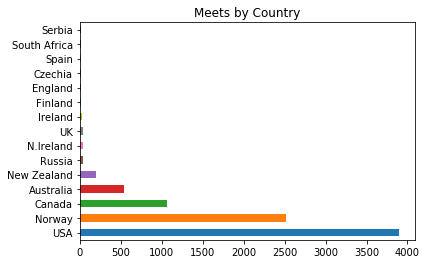

In [4]:
meets_df.MeetCountry.value_counts()[:15].plot(kind='barh')
type(meets_df.MeetCountry.value_counts())
plt.title('Meets by Country')
plt.show()

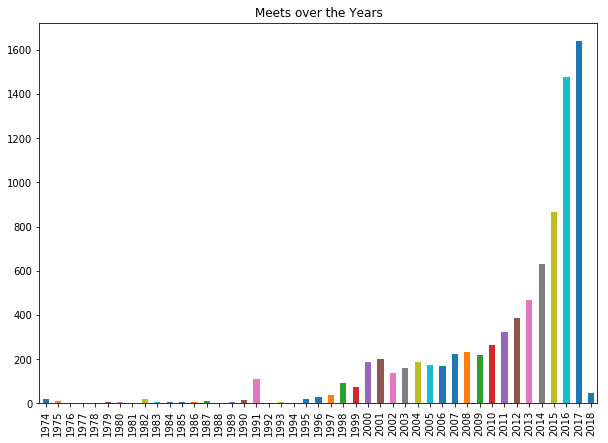

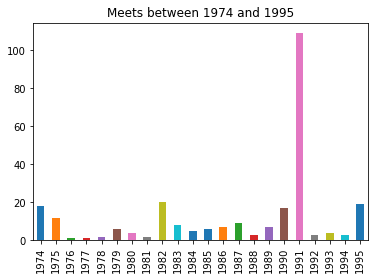

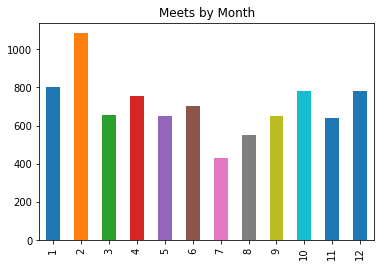

In [5]:
plt.figure(figsize=(10,7))
meets_df.Year.value_counts(sort=False).sort_index().plot(kind='bar')
plt.title('Meets over the Years')
plt.show()
meets_df.Year[(meets_df.Year < 1996) &(meets_df.Year >= 1974)].value_counts().sort_index().plot(kind='bar')
plt.title('Meets between 1974 and 1995')
plt.show()
meets_df.Month.value_counts().sort_index().plot(kind='bar')
plt.title('Meets by Month')
plt.show()

When plotting the total meets by year, from the beginning of the recorded dataset to the most recent (early 2018), it was noticed that there was a large jump in 1991, unsure why this is, we'll explore the ~100 meets for that year to see if there is anything that looks incorrect with the data. Otherwise, it looks about as expected, with more competitions forming over the years as the popularity of the sport grew, as well as the overall population.

As for when meets take place, February seems to be the most popular month. 

Now we're going to look at the competitors dataframe to see what sort of data it holds. We'll start again by looking at the first few rows, the info to look for missing values, and then describe to see if there are any obvious outliers. 

In [6]:
print(competitors_df.shape)
print(competitors_df.head())
print(competitors_df.info(verbose=True))
print(competitors_df.describe())

(386414, 17)
   MeetID              Name Sex   Equipment   Age     Division  BodyweightKg  \
0       0  Angie Belk Terry   F       Wraps  47.0    Mst 45-49         59.60   
1       0       Dawn Bogart   F  Single-ply  42.0    Mst 40-44         58.51   
2       0       Dawn Bogart   F  Single-ply  42.0  Open Senior         58.51   
3       0       Dawn Bogart   F         Raw  42.0  Open Senior         58.51   
4       0      Destiny Dula   F         Raw  18.0   Teen 18-19         63.68   

  WeightClassKg  Squat4Kg  BestSquatKg  Bench4Kg  BestBenchKg  Deadlift4Kg  \
0            60       NaN        47.63       NaN        20.41          NaN   
1            60       NaN       142.88       NaN        95.25          NaN   
2            60       NaN       142.88       NaN        95.25          NaN   
3            60       NaN          NaN       NaN        95.25          NaN   
4          67.5       NaN          NaN       NaN        31.75          NaN   

   BestDeadliftKg  TotalKg Place   Wi

Right off there are a few things that look off with the data. For all the lift values, there are minimums that are negative. These were lifts that didn't qualify. For this data, we'll inspecty how many lifts were report as negative and determine how they should be handled. If there are a small number, we'll drop those records that contain negative lift values.

Something interesting in the Age column, is that the youngest lifter that has competed is 5, and the oldest, 95. 

We also see that the Bench4Kg, Deadlift4Kg, and Squat4Kg columns are missing a large amount of data. For these, we'll drop the columns entirely. 

Another thing that will be considered, is what columns can be changed to categories. 

It seems the best way to uniquely identify a row is through MeetID and Name; these will be used for joint indexing. 

In [7]:
comps_slim = competitors_df.drop(['Squat4Kg', 'Bench4Kg', 'Deadlift4Kg'], axis=1)
comps_slim.columns


Index(['MeetID', 'Name', 'Sex', 'Equipment', 'Age', 'Division', 'BodyweightKg',
       'WeightClassKg', 'BestSquatKg', 'BestBenchKg', 'BestDeadliftKg',
       'TotalKg', 'Place', 'Wilks'],
      dtype='object')

In [8]:
comps_slim.Equipment = comps_slim.Equipment.astype('category')
comps_slim.Sex = comps_slim.Sex.astype('category')
print(comps_slim.Sex.unique()) 
print(comps_slim.Equipment.unique())

[F, M]
Categories (2, object): [F, M]
[Wraps, Single-ply, Raw, Multi-ply, Straps]
Categories (5, object): [Wraps, Single-ply, Raw, Multi-ply, Straps]


In [9]:
# Determine how frequent negative values occur by including any rows with at least 1 negative lift, 
# then dividing that number of rows by the total number in the dataframe.
percent_neg = len(comps_slim[(comps_slim['BestSquatKg'] < 0) | (comps_slim['BestBenchKg'] < 0) | (comps_slim['BestDeadliftKg'] < 0)])/len(comps_slim)
print('Percentage of lifts that are negative: ', str(percent_neg*100))

Percentage of lifts that are negative:  0.7554074127748994


Since it's a small percentage of records that contain a negative value, we'll drop those, and make sure we don't drop null rows as well. 

In [10]:
comps_slim = comps_slim[(comps_slim.BestBenchKg > 0) | comps_slim.BestBenchKg.isnull()]
comps_slim = comps_slim[(comps_slim.BestSquatKg > 0) | comps_slim.BestSquatKg.isnull()]
comps_slim = comps_slim[(comps_slim.BestDeadliftKg > 0) | comps_slim.BestDeadliftKg.isnull()]


We want to look farther into missing values, such as those in the BodyweightKg and WeightClasskg. Depending on how many there are, we may just remove all those rows. If there are too many, we'll look at removing only those missing both BodyweightKg and WeightClassKg, Since BodyweightKg within a WeightClassKg is used to determind placement, we will need to remove all rows that have a missing BodyWeight. However, if we are just missing WeightClassKg, we can try to fit it into one of the WeightClassKg based off Sex / BodyweightKg.

In [11]:
comps_slim = comps_slim[(comps_slim.WeightClassKg.notnull())]
#print(comps_slim.info())
females = comps_slim[comps_slim.Sex == 'F']
males = comps_slim[comps_slim.Sex == 'M']
print(females.info())
print(males.info())
print(females.WeightClassKg.unique())
print(males.WeightClassKg.unique())

comps_slim = comps_slim[(comps_slim.BodyweightKg.notnull())]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86021 entries, 0 to 386401
Data columns (total 14 columns):
MeetID            86021 non-null int64
Name              86021 non-null object
Sex               86021 non-null category
Equipment         86021 non-null category
Age               42298 non-null float64
Division          81800 non-null object
BodyweightKg      85788 non-null float64
WeightClassKg     86021 non-null object
BestSquatKg       70066 non-null float64
BestBenchKg       81109 non-null float64
BestDeadliftKg    76579 non-null float64
TotalKg           83665 non-null float64
Place             85789 non-null object
Wilks             83442 non-null float64
dtypes: category(2), float64(7), int64(1), object(4)
memory usage: 8.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 293666 entries, 23 to 386413
Data columns (total 14 columns):
MeetID            293666 non-null int64
Name              293666 non-null object
Sex               293666 non-null category
Equi

After farther examination, it shows that weight classes are not consistent across all Divisions, and trying to reclassify the missing BodyweightKg values would be tough, and not that much more insightful, seeing how few rows were missing it from the whole dataset. 

Missing values for BestSquatKg, BestBenchKg, and BestDeadliftKg are expected, as not everyone is successful at their lifts. Missing Ages may be problematic for viewing age distributions, but we can't disregard all rows that are missing these values becaus we'd lose far too much data. 

I'll display the breakout of ages across all lifters, distinguishing between male / female to see how the age of lifters corresponds to Sex, if at all. 

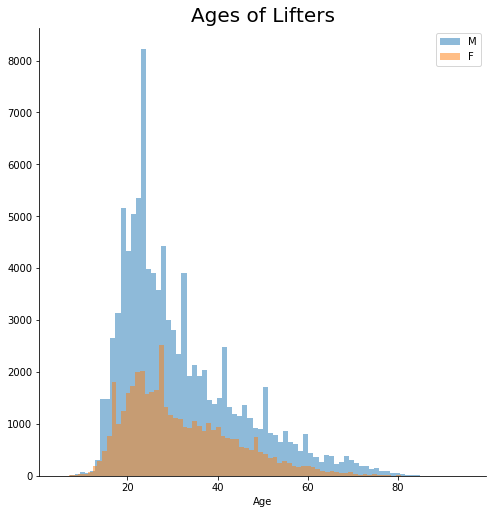

In [12]:
df_with_ages = comps_slim[comps_slim.Age.notnull()]
graph = sns.FacetGrid(df_with_ages,hue='Sex', legend_out=True, hue_order=['M', 'F'], height=7)
graph.map(plt.hist,'Age',bins=80,alpha=.5)
plt.title('Ages of Lifters',fontsize=20)
plt.legend(loc=1)
plt.show()

As noted earlier, we observerd the minimum age as 5 years old, and the maximum of 95. Let's take a closer look at lifters under 10, and those above 80. 

In [19]:
print(df_with_ages[(df_with_ages.Age <= 7)])
print(df_with_ages[(df_with_ages.Age >= 90)])

        MeetID              Name Sex Equipment  Age      Division  \
817         15  Celleste Lindsay   F       Raw  7.0        RY 6-7   
1018        16  Matthew Martinez   M       Raw  5.0            Y5   
2257        50  Anderson Coleman   M       Raw  7.0  Tested Youth   
129964    4882      Caden Cooper   M       Raw  6.0      Pre Teen   
162794    5489  Kylie McElhannon   F       Raw  7.0         Youth   
172556    5713    Payton Barabas   M       Raw  7.0      Pre-teen   
172991    5725     William Whitt   M       Raw  6.0       Juniors   
233989    6405  Zachary Jaakkola   M       Raw  7.0      AD M-RT1   
236161    6445      Laila Thomas   F       Raw  6.0           F-T   
236162    6445       Hayden Meek   M       Raw  6.0           M-T   
236166    6445       Madden Meek   M       Raw  5.0           M-T   
372840    8313  Berlynn Shamblin   F       Raw  6.0        Junior   

        BodyweightKg WeightClassKg  BestSquatKg  BestBenchKg  BestDeadliftKg  \
817            32.11  

Some columns that have yet to be explore in this dataset are the three best lifts, bodyweight, the total, equipment, and place. 

Next we'll take a look at what equipment is most popular, then we'll start diving into the best lifts. To explore these, we'll need to take into consideration the age, weight, and equipment used by the lifters. 

In [21]:
comps_slim.Equipment.value_counts()

Raw           183667
Single-ply    140928
Wraps          44907
Multi-ply       9183
Straps             7
Name: Equipment, dtype: int64

There are only 7 instances of Straps, which I believe are the same as Wraps. We'll now change any rows affected by this mistake and graph out the distribution. 

Text(0.5, 1.0, 'Equipment Usage')

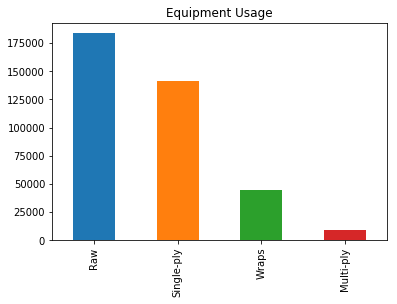

In [28]:
comps_slim.Equipment = comps_slim.Equipment.apply(lambda x: 'Wraps' if x == 'Straps' else x)
comps_slim.Equipment.value_counts().plot(kind='bar')
plt.title('Equipment Usage')

We'll now reclassify ages based on USAPL age divisions found on https://en.wikipedia.org/wiki/USA_Powerlifting. Because they don't have a youth category, we'll also create that for lifters under 14 so that they're not included in 'OPEN'. Since there are different age groups for males and females, we'll split the dataframe by Sex then apply 

In [74]:
def age_class_male(x):
    if x < 14:
        return 'YOUTH'
    elif x < 18:
        return 'SUB-JUNIOR'
    elif x < 23:
        return 'JUNIOR'
    elif (x >= 40) & (x <= 49):
        return 'MASTER I'
    elif (x >= 50) & (x <= 59):
        return 'MASTER II'
    elif (x >= 60) & (x <= 65):
        return 'MASTER III'
    elif (x >= 66) & (x <= 69):
        return 'MASTER IV'
    elif (x >= 70):
        return 'GRANDMASTER'
    else:
        return 'OPEN'
def age_class_female(x):
    if x < 14:
        return 'YOUTH'
    elif x < 18:
        return 'SUB-JUNIOR'
    elif x < 23:
        return 'JUNIOR'
    elif (x >= 40) & (x <= 49):
        return 'MASTER I'
    elif (x >= 50):
        return 'MASTER II'
    else:
        return 'OPEN'
males_with_ages = males[males.Age.notnull()]
females_with_ages = females[females.Age.notnull()]
males_with_ages.Age = males_with_ages.Age.astype(int)
females_with_ages.Age = females_with_ages.Age.astype(int)
males_with_ages['AgeGroup'] = males_with_ages.Age.apply(age_class_male)
females_with_ages['AgeGroup'] = females_with_ages.Age.apply(age_class_female)


C:\Users\sarah\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sarah\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now we'll recombine the males_with_ages and females_with_ages, and put any null values from before back into the dataframe in the group "OPEN". After, we'll create a graph to show distributions of lifters based on age group. 

In [75]:
competitors_with_ages = pd.concat([males_with_ages, females_with_ages])
missing_age = comps_slim[comps_slim.Age.isnull()]
missing_age['AgeGroup'] = 'OPEN'
competitors = pd.concat([competitors_with_ages, missing_age])
competitors.info()

C:\Users\sarah\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'pandas.core.frame.DataFrame'>
Int64Index: 378793 entries, 23 to 386413
Data columns (total 15 columns):
MeetID            378793 non-null int64
Name              378793 non-null object
Sex               378793 non-null category
Equipment         378793 non-null object
Age               142281 non-null float64
Division          363354 non-null object
BodyweightKg      378692 non-null float64
WeightClassKg     378793 non-null object
BestSquatKg       293511 non-null float64
BestBenchKg       350993 non-null float64
BestDeadliftKg    313788 non-null float64
TotalKg           360021 non-null float64
Place             377791 non-null object
Wilks             359942 non-null float64
AgeGroup          378793 non-null object
dtypes: category(1), float64(7), int64(1), object(6)
memory usage: 43.7+ MB


[OPEN, JUNIOR, MASTER I, SUB-JUNIOR, MASTER II, MASTER IV, MASTER III, GRANDMASTER, YOUTH]
Categories (9, object): [OPEN, JUNIOR, MASTER I, SUB-JUNIOR, ..., MASTER IV, MASTER III, GRANDMASTER, YOUTH]
[OPEN, JUNIOR, MASTER I, SUB-JUNIOR, MASTER II, MASTER IV, MASTER III, GRANDMASTER, YOUTH]
Categories (9, object): [OPEN, JUNIOR, MASTER I, SUB-JUNIOR, ..., MASTER IV, MASTER III, GRANDMASTER, YOUTH]


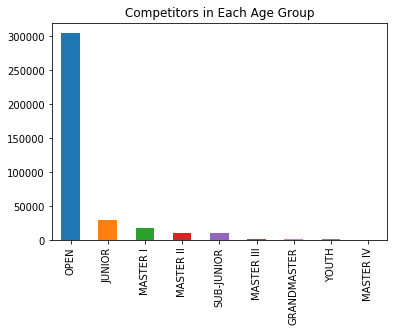

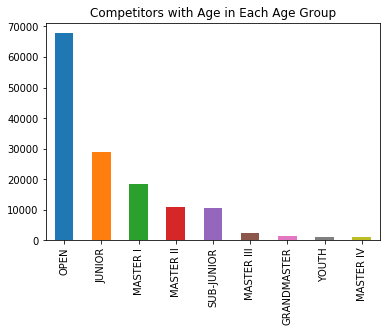

In [76]:
competitors.AgeGroup = competitors.AgeGroup.astype('category')
competitors_with_ages.AgeGroup = competitors_with_ages.AgeGroup.astype('category')
print(competitors.AgeGroup.unique())
print(competitors_with_ages.AgeGroup.unique())

competitors.AgeGroup.value_counts().plot(kind='bar')
plt.title('Competitors in Each Age Group')
plt.show()
competitors_with_ages.AgeGroup.value_counts().plot(kind='bar')
plt.title('Competitors with Age in Each Age Group')
plt.show()

Looking at these two graphs, the first including all those that were missing ages, the second only those with ages, we see how many people are missing ages. We also can tell that OPEN is the most popular, which means ages 24-39 is the most common for participation. This is expected. 

The next thing we should look at is bodyweight distributions. 


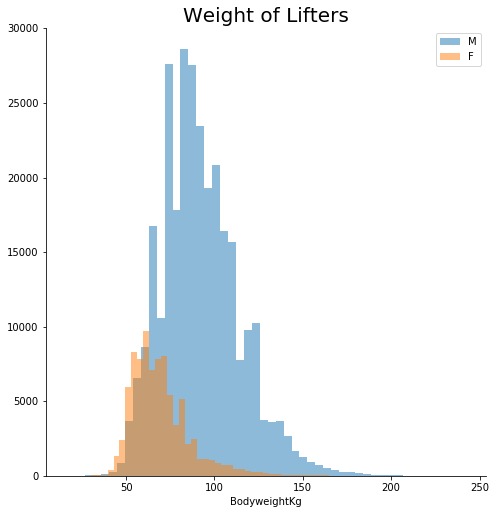

In [78]:
graph = sns.FacetGrid(competitors,hue='Sex', legend_out=True, hue_order=['M', 'F'], height=7)
graph.map(plt.hist,'BodyweightKg',bins=50,alpha=.5)
plt.title('Weight of Lifters',fontsize=20)
plt.legend(loc=1)
plt.show()

This histogram shows that male lifters tend to be heavier than female lifters. This makes sense as males tend to be heavier. 

Getting to the fun part, we will next look at the best lifts, and how these values correlate to Age, WeightClass, Sex, and equipment used. 

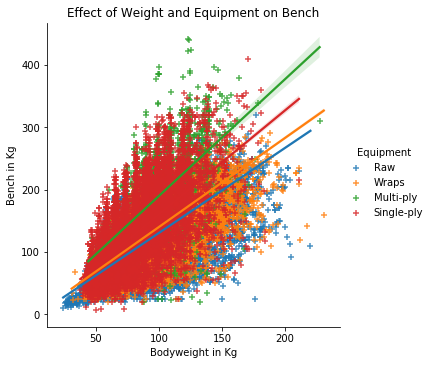

In [92]:
g1 = sns.lmplot(x="BodyweightKg", y="BestBenchKg", hue="Equipment", height=5, truncate=True, data=competitors.dropna(), markers='+')
plt.title('Effect of Weight and Equipment on Bench')
plt.xlabel('Bodyweight in Kg')
plt.ylabel('Bench in Kg')
plt.show()



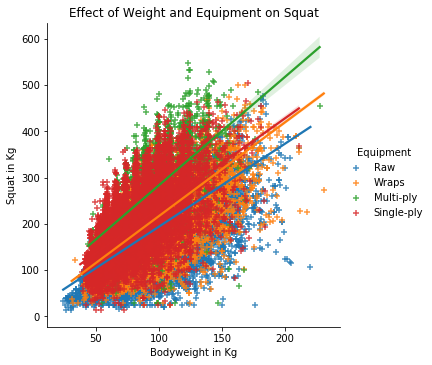

In [93]:
g2 = sns.lmplot(x="BodyweightKg", y="BestSquatKg", hue="Equipment", truncate=True, height=5, data=competitors.dropna(), markers='+')
plt.title('Effect of Weight and Equipment on Squat')
plt.xlabel('Bodyweight in Kg')
plt.ylabel('Squat in Kg')
plt.show()



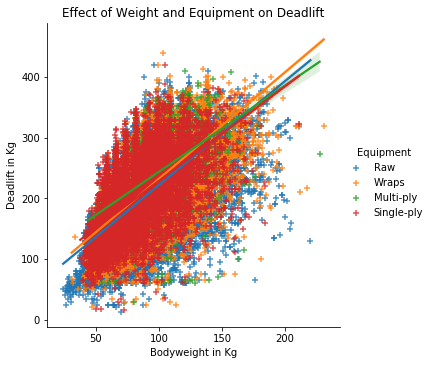

In [94]:
g3 = sns.lmplot(x="BodyweightKg", y="BestDeadliftKg", hue="Equipment", truncate=True, height=5, data=competitors.dropna(), markers='+')
plt.title('Effect of Weight and Equipment on Deadlift')
plt.xlabel('Bodyweight in Kg')
plt.ylabel('Deadlift in Kg')
plt.show()


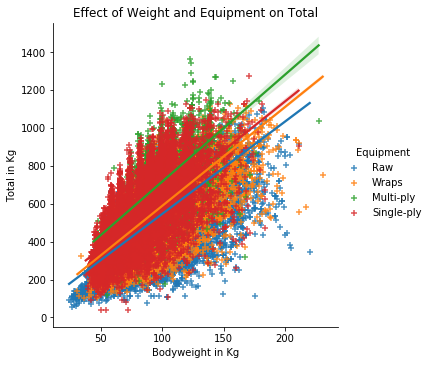

In [95]:
g4 = sns.lmplot(x="BodyweightKg", y="TotalKg", hue="Equipment", truncate=True, height=5, data=competitors.dropna(), markers='+')
plt.title('Effect of Weight and Equipment on Total')
plt.xlabel('Bodyweight in Kg')
plt.ylabel('Total in Kg')
plt.show()

For both Bench and Squat, the graphs look quite similar with Multi-ply dominating all other equipment types, and "raw" doing considerably worse. However, on Deadlifts, the spreadout between equipment doesn't seem to be as far apart, with "Wraps" and "raw" performing better at high bodyweights. 

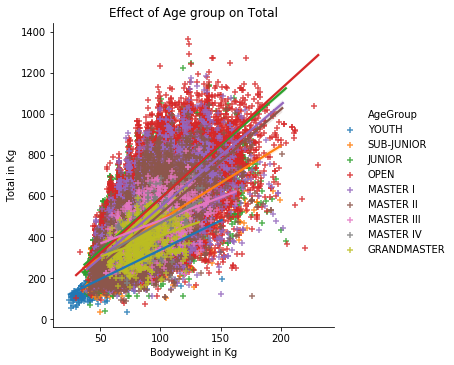

In [98]:
#Age vs lift
g4 = sns.lmplot(x="BodyweightKg", y="TotalKg", hue="AgeGroup", truncate=True, height=5, data=competitors.dropna(), markers='+', hue_order=['YOUTH', 'SUB-JUNIOR', 'JUNIOR', 'OPEN', 'MASTER I', 'MASTER II', 'MASTER III', 'MASTER IV', 'GRANDMASTER'])
plt.title('Effect of Age group on Total')
plt.xlabel('Bodyweight in Kg')
plt.ylabel('Total in Kg')
plt.show()

Looking at this chart, it's a little surprising to see the Junior category is so closely competitive to the open age group. Also, the Master III age group actually competes better than Junior and Oppen at low bodyweights! 

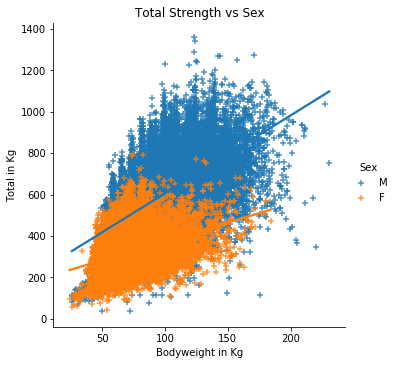

In [99]:
#Sex vs lift
sns.lmplot(x="BodyweightKg", y="TotalKg", hue="Sex", truncate=True, height=5, data=competitors.dropna(), markers='+', hue_order=['M', 'F'])
plt.title('Total Strength vs Sex')
plt.xlabel('Bodyweight in Kg')
plt.ylabel('Total in Kg')
plt.show()

While there are a few females (outliers) that actively life close to the same as males in the same weight classes, overall males lift more. Males tend to gain more strength per added bodyweight than females do. Based off the distributions, it appears that around 125Kg is optimal for male lifters, and about 65Kg for females. 

Now, we need to join the two tables to look more closely at distributions of males / females over the years, and where these lifters compete. 